# Wine scoring prediction

In this notebook we will predict points assigned to a wine by a taster. The dataset comes from https://www.kaggle.com/zynicide/wine-reviews.



In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

/home/bartek/anaconda3/envs/ds/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
data = pd.read_csv("../data_root/raw/wine_dataset.csv", index_col="Unnamed: 0")

In [22]:
data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Fragrances suggest hay, crushed tomato vine an...",Kirchleiten,90,30.0,Northeastern Italy,Alto Adige,NaN,Kerin O’Keefe,@kerinokeefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon,Tiefenbrunner
1,France,"Packed with fruit and crisp acidity, this is a...",NaN,87,22.0,Loire Valley,Sancerre,NaN,Roger Voss,@vossroger,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé,Bernard Reverdy et Fils
2,Italy,"This easy, ruby-red wine displays fresh berry ...",NaN,86,NaN,Tuscany,Chianti Classico,NaN,NaN,NaN,Dievole 2009 Chianti Classico,Sangiovese,Dievole
3,US,Pretty in violet and rose petals this is a low...,Horseshoe Bend Vineyard,92,50.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Davis Family 2012 Horseshoe Bend Vineyard Pino...,Pinot Noir,Davis Family
4,US,This golden wine confounds in a mix of wet sto...,Dutton Ranch,93,38.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Dutton-Goldfield 2013 Dutton Ranch Chardonnay ...,Chardonnay,Dutton-Goldfield


In [23]:
data.describe()

,points,price
count,10000.000000,9323.000000
mean,88.460000,35.447603
std,3.030003,40.898626
min,80.000000,5.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,1300.000000


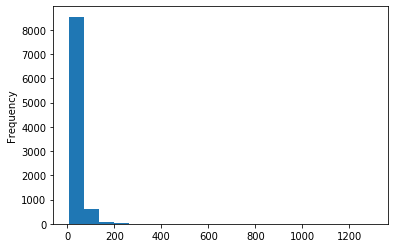

In [24]:
data['price'].plot.hist(bins=20)

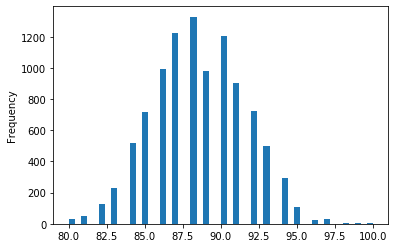

In [25]:
data['points'].plot.hist(bins=50)

Our target value is close to be normally distributed.
Price column have some very big outliers. While it is possible to have a very expensive wine in a dataset, we prefer to focus on the majority of products that cost below 200 dollars.

Before cleaning the data, we extract years from wine titles

In [26]:
yearSearch = []    
for value in data['title']:
    regexresult = re.search(r'19\d{2}|20\d{2}', value)
    if regexresult:
        yearSearch.append(int(regexresult.group()))
    else: 
        yearSearch.append(None)
        
data['year'] = yearSearch
data = data.dropna(subset=['year'])

array([[1.        , 0.07225584],
       [0.07225584, 1.        ]])

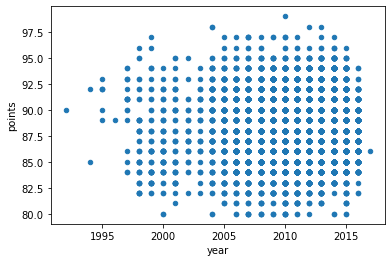

In [32]:
data.plot.scatter(x='year', y='points')
my_rho = np.corrcoef(data['year'], data['points'])
my_rho

There is no linear correlation between age of wine and it's grade. However, we know that weather in some years can impact quality of grapes, so this feature will be treated as categorical.

## Data preprocessing

In [28]:
data = data[data['year']>=1990]
data = data[data['price']<200]

We cut outliers from `year` and `price` columns

In [29]:
for column in data:
    print( str(column) + " " + str(sum(data[column].isna())))

country 5
description 0
designation 2619
points 0
price 0
province 5
region_1 1481
region_2 5162
taster_name 1777
taster_twitter_handle 2129
title 0
variety 0
winery 0
year 0


In [30]:
for feature in data:
    print (feature + " " + str(data[feature].nunique()))

country 37
description 8880
designation 4788
points 20
price 139
province 238
region_1 671
region_2 17
taster_name 18
taster_twitter_handle 14
title 8879
variety 319
winery 4957
year 25


We have a lot of NaN values in the dataset. They will be handeled in different ways, with respect to column quality.

There are almost 5k wineries in 10k of records, so this feature will be also dropped as it would be very hard to use it for prediction.

In [16]:
data = data.drop("region_2", axis=1)
data = data.drop("taster_twitter_handle", axis=1)
data = data.drop("designation", axis=1)

data = data.drop("region_1", axis=1)
data = data.drop("winery", axis=1)

data = data.dropna(subset=['country', 'province', 'price'])

In [17]:
data[ ['taster_name']] = data[[ 'taster_name']].fillna('Unknown')

We will separate train and test datasets, in order to conduct fair feature engineering.

In [18]:
l_features = ['country','description', 'price', 'province', 'variety', 'taster_name', 'year']
X_train, X_test, y_train, y_test = train_test_split(data[l_features], data['points'], test_size=0.1, random_state=42)

Data in selected columns is typically categorical, so we perform OneHot Encoding on those features.

In [31]:
ohe = OneHotEncoder(cols=['country','taster_name', 'year', 'province', 'variety']).fit(X_train)
X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

/home/bartek/anaconda3/envs/ds/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


We will use a square of price to obtain better linear correlation with graded points.

In [33]:
X_train['price'] = np.sqrt(X_train['price'])
X_test['price'] = np.sqrt(X_test['price'])

### Extract vectors from description 

Descritpions contain a lot of informations about impression that wine made on a taster. We will extract them as `tf_idf` vectors.

In [34]:
ps = PorterStemmer()

def clean(text, stemmer):
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    text = [stemmer.stem(word) for word in text.split()]
    text = ' '.join(text)
    return text


X_train['description'] = X_train['description'].apply(clean, args = (ps,))
X_test['description'] = X_test['description'].apply(clean, args = (ps,))

In [35]:
def extract_words(train, test):
    tfidf = TfidfVectorizer(stop_words = ['english'])
    extracted_train = tfidf.fit_transform(train['description'].values.astype('U'))
    df1 = pd.DataFrame(extracted_train.toarray(), columns=tfidf.get_feature_names())
    train.reset_index(drop=True, inplace=True)
    train = pd.concat([train, df1], axis=1)

    extracted_test = tfidf.transform(test['description'].values.astype('U'))
    df2 = pd.DataFrame(extracted_test.toarray(), columns=tfidf.get_feature_names())
    test.reset_index(drop=True, inplace=True)
    test = pd.concat([test, df2], axis=1)
    return train, test

In [36]:
X_train, X_test = extract_words(X_train, X_test)

In [37]:
tfidf = TfidfVectorizer(stop_words = ['english'])
train = tfidf.fit_transform(X_train['description'].values.astype('U'))
df1 = pd.DataFrame(train.toarray(), columns=tfidf.get_feature_names())
X_train.reset_index(drop=True, inplace=True)
X_train = pd.concat([X_train, df1], axis=1)

In [38]:
test = tfidf.transform(X_test['description'].values.astype('U'))
df2 = pd.DataFrame(test.toarray(), columns=tfidf.get_feature_names())
X_test.reset_index(drop=True, inplace=True)
X_test = pd.concat([X_test, df2], axis=1)

In [39]:
X_train=X_train.drop('description', axis=1)
X_test=X_test.drop('description', axis=1)

## Model creation

In [43]:
#regression = RandomForestRegressor()
regression = Ridge()
regression.fit(X_train, y_train)

Ridge()

## Performance evaluation

In [44]:
pred_test = regression.predict(X_test)
pred_test = pd.Series(pred_test)

In [45]:
rmse = mean_squared_error(pred_test, y_test.astype(float), squared=False)
mse = mean_squared_error(pred_test, y_test.astype(float))
mae = mean_absolute_error(pred_test, y_test.astype(float))
print("Mean absolute error: " + str(mae))
print("Mean squared error: " + str(mse))
print("Root mean squared error: " + str(rmse))

Mean absolute error: 1.3297602665199457
Mean squared error: 2.948022120866354
Root mean squared error: 1.7169805243118963


In [46]:
y_test.index = range(len(y_test))
error = y_test.astype(float) - pred_test.astype(float)

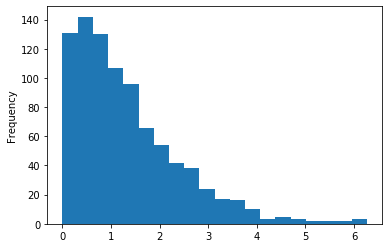

In [47]:
error.abs().plot.hist(bins=20)

Almost all predictions missed the target by less than 3. Considering scope of points from 80 to 100 this is pretty good result.

[Text(0, 0.5, 'count'), Text(0.5, 0, 'error')]

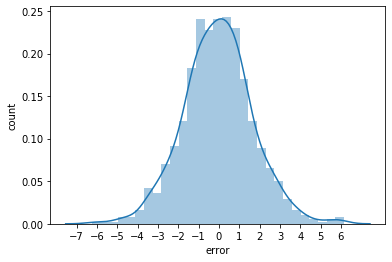

In [48]:
g = sns.distplot(error)
g.set_xticks(range(-7,7,1)); # <--- set the ticks first
g.set(xlabel='error', ylabel='count')

Distribution of errors is symmetrical, so model is not biast toward high or low values.

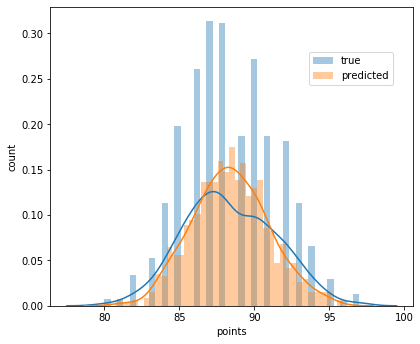

In [49]:
fig, ax = plt.subplots(figsize=(6.5,5.5))
for a in [y_test, pred_test]:
    sns.distplot(a, bins=40, ax=ax)
fig.legend(labels=['true','predicted'], bbox_to_anchor=(0.85, 0.75))
ax.set(xlabel='points', ylabel='count')
plt.savefig('predicted_and_true.png')

Both plots are very close to each other, which shows that model works
well with both often occuring grades close to the dataset’s mean and
exceptionally high or low vales.

Predictions’, comparing to true values’ distribution, is slightly more
focused around the mean. This means that most of errors comes from
underestimating very high values or overestimating very low values. That type
of errors is usually safer than predicting too extreme grades and doesn’t come
with serious consequences.

In [50]:
features = X_test.columns
importance = regression.coef_
zipped = zip(features, importance)
dictionary = dict(zipped)

In [52]:
{k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1], reverse=True)}

{'beauti': 2.770642702978275,
 'gorgeou': 2.565240454692865,
 'wonder': 2.489170124043191,
 'impress': 2.128226282886361,
 'eleg': 2.1207544637194182,
 'long': 2.1156235429313948,
 'br': 2.0643544579705004,
 'variety_265': 2.007850330336718,
 'detail': 2.002992323952731,
 'province_75': 1.970103853185811,
 'love': 1.954521439728246,
 'delici': 1.9324968782369434,
 'decad': 1.9307261872966606,
 'brilliant': 1.9288378031087003,
 'consider': 1.8837171914932878,
 'variety_56': 1.8821244608189565,
 'variety_204': 1.8603210938125363,
 'tremend': 1.8130166878412124,
 'year': 1.80733391063725,
 'amazingli': 1.802020965226725,
 'succul': 1.7724997621159297,
 'riper': 1.757116523973077,
 'rich': 1.7444584987644203,
 'slow': 1.7409550793578115,
 'strength': 1.7288610536715476,
 'miner': 1.6936121309049261,
 'stun': 1.6907634485389171,
 'sophist': 1.6807711322055365,
 'complex': 1.6785786937939644,
 'delight': 1.6783156815754017,
 'lusciou': 1.6505828806561236,
 'power': 1.6250312348020723,
 'sedu

Adjectives extracted from description and categorical variables have big influence on predictions.

## Conclusion

We have managed to create a good, functional model for predicting wine
points grading. Our solution misses the true value by 1.29 on average, mostly in
the direction of all points mean.

Created model makes prediction basing on wine description, taster's name, wine variety, it's year and origin.

For further improvement, we could leaverage data from dropped features or different option of